In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 27.3 MB/s 
  Created wheel for pyod: filename=pyod-1.0.3-py3-none-any.whl size=154726 sha256=0eda1eaa7288371f97e50d30138b7faa05a054f3822b9bf38ebdc0cf465e7fca
  Stored in directory: /root/.cache/pip/wheels/60/1e/04/b42e786399bd7503af674d1ec95d93665b1700309ec3525b65
Successfully built pyod


In [4]:
!pip install combo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42884 sha256=0abecbedece2ab8cca911d23624165f14be69e8e4b8207352c582e72d3c4922a
  Stored in directory: /root/.cache/pip/wheels/b1/6e/c9/89dab355d4d5d58b11fe135b5839e8a3acc8b73273ffc68cde
Successfully built combo


In [5]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("white")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score,\
    silhouette_score, f1_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score,\
    silhouette_score, f1_score
from pyod.models import knn, lof, hbos, iforest,ocsvm


from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.feature_bagging import FeatureBagging
def train_test(clf, X_train, X_test):
    # get the prediction label and outlier scores of the training data
    start = time.time()
    clf.fit(X_train)
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores
    end_train = time.time()
    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    end = time.time()
    time_to_train = end_train-start
    time_to_test = end-end_train
    span = end - start
    print("Total time: ", span, "s.")

    return y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test

def co_train_test(clf, X_train, X_test):
    # get the prediction label and outlier scores of the training data
    start = time.time()
    clf.fit(X_train)
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores
    end_train = time.time()
    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    end = time.time()
    time_to_train = end_train-start
    time_to_test = end-end_train
    span = end - start
#    print("Train time: ", time_to_train, "s.")
#    print("Test time: ", time_to_test, "s.")
    

    return y_train_pred, y_train_scores, y_test_pred, y_test_scores,clf.threshold_, time_to_train, time_to_test 

def my_metric(label,predict):
    CM = confusion_matrix(label,predict)
    CR = classification_report(label,predict)
    fpr, tpr, thresholds = roc_curve(label, predict)
    precision=precision_score(label, predict)
    recall=recall_score(label, predict)
    accuracy = accuracy_score(label, predict)
    f1=f1_score(label, predict, average='weighted')
    #AUC = auc(fpr, tpr)
    AUC=metrics.auc(fpr, tpr)

    results = {"Confusion Matrix":CM,"Classification Report":CR,"Area Under Curve":AUC}

    # show results
    for measure in results:
        print(measure,": \n",results[measure])
#     plt.plot(fpr, recall, 'k--', label='ROC (area = {0:.2f})'.format(AUC), lw=2)
    return fpr,tpr,f1,AUC, recall, accuracy
def baseline(X_train, X_test, y_train, y_test,model):
    start = time.time()

    if model == "knn":
        print ("Base Detector:"+model)
        clf = knn.KNN()
    elif model == "lof":
        print ("Base Detector:"+model)
        clf = lof.LOF()
    elif model == "hbos":
        print ("Base Detector:"+model)
        clf = hbos.HBOS()
    elif model == "iforest":
        print ("Base Detector:"+model)
        clf = iforest.IForest()
    elif model== "ocsvm":
        print ("Base Detector:"+model)
        clf = ocsvm.OCSVM()
    else:
        print("Please select a correct base model!")
    y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test= train_test(clf, X_train, X_test)
    print("\nTraining set:\n")
    _, _, _, _ ,_, _ = my_metric(y_train, y_train_pred)
    print("\nTest set:\n")
    fpr, tpr, f1, auc, recall, accuracy= my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train, time_to_test, recall, accuracy
def feature_bagging(X_train, X_test, y_train, y_test,basemodel,combination_function="mean"):

    start = time.time()
    #print ("FB base detector:"+basemodel)


    # train Feature Bagging detector
    clf_name = 'FeatureBagging'
    if basemodel=="knn":
        base_estimator=knn.KNN()
    elif basemodel=="lof":
        base_estimator = lof.LOF()
    elif basemodel == "hbos":
        base_estimator = hbos.HBOS()
    elif basemodel == "iforest":
        base_estimator = iforest.IForest()
    elif basemodel== "ocsvm":
        base_estimator = ocsvm.OCSVM()
    else:
        print("Please select a correct base model!")
    if combination_function=="mean":
        clf = FeatureBagging(base_estimator=base_estimator,check_estimator=False)
    else:
        clf = FeatureBagging(base_estimator=base_estimator,check_estimator=False,combination='max')
    # params
    clf.fit(X_train)

    print("Feature Bagging:")
    y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test = train_test(clf, X_train, X_test)
    print("training set:")
    _,_,_,_, _, _=my_metric(y_train, y_train_pred)
    print("test set:")
    fpr,tpr,f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)
    print("f1:",f1,"auc:",auc)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train, time_to_test,  recall, accuracy
def minmax(x):
    min=x.min()
    max=x.max()
    x = (x - min) / (max - min)
    return x,min,max
def parameter_ensemble(X_train, X_test, y_train, y_test,basemodel,combination_function="mean",span=10):
    #span :Determine the number of different parameters
    start = time.time()
    #print ("PR base detector:"+basemodel)
    threshold = []
    train_score=[]
    test_score=[]#np.zeros([X_test.shape[0],span])
    time_to_train=0
    time_to_test=0
    
    # for i in range(low, high + 1):
    for i in range(0, span):

        if basemodel == "knn":
            clf = knn.KNN(n_neighbors=i+5)
        elif basemodel == "lof":
            clf = lof.LOF(n_neighbors=i+20)
        elif basemodel == "hbos":
            clf = hbos.HBOS(n_bins=10+i)
        elif basemodel == "iforest":
            clf = iforest.IForest(n_estimators=i+100)
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM(degree=i+3)
        else:
            print("Please select a correct base model!")
        print("parameter ensemble:")

        y_train_pred, y_train_scores, y_test_pred, y_test_scores,threshold0, time_to_train0, time_to_test0= co_train_test(clf, X_train, X_test)
        #_, y_train_scores, y_test_pred, y_test_scores,threshold0, time_to_train0, time_to_test0= train_test(clf, X_train, X_test)
        time_to_train=time_to_train+time_to_train0
        time_to_test=time_to_test+time_to_test0
        _, _, f1, auc ,  recall, accuracy= my_metric(y_test, y_test_pred)

        y_test_scores=np.expand_dims(y_test_scores,-1)
        y_test_scores,min,max=minmax(y_test_scores)
        threshold0=(threshold0-min)/(max-min)
        test_score.append(y_test_scores)
        threshold.append(threshold0)
    print("PE Total time: ", time_to_train+time_to_test, "s.") 
    if combination_function=="mean":
        test_score = np.array(test_score).mean(0)
        threshold = np.array(threshold).mean()
    elif combination_function=="max":
        test_score = np.array(test_score).max(0)
        threshold = np.array(threshold).max()
    elif combination_function=="median":
        test_score =np.median(np.array(test_score),0)
        threshold = np.median(np.array(threshold),0)
    else:
        print("Please select a correct combination function!")
    # threshold = threshold/span
    
    
    print("training set:")
    fpr,tpr,f1, auc, recall, accuracy =my_metric(y_train, y_train_pred)
    print("test set:")
    fpr,tpr,f1, auc , recall, accuracy= my_metric(y_test, y_test_pred)
    #print("f1:",f1,"auc:",auc)
    
    y_test_pred = np.array(test_score > threshold).astype(np.int).flatten()
    fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train0, time_to_test0, recall, accuracy

def gram_schmidt(data):
    r, c = data.shape
    data = data.astype("float64")
    data[:, 0] = data[:, 0] / np.linalg.norm(data[:, 0])
    for j in range(1, c):
        y = data[:, j]
        sum = np.zeros((r,))
        for i in range(j):
            sum += np.dot(y, data[:, i]) * data[:, i]
        y -= sum
        y = y / np.linalg.norm(y)
        data[:, j] = y
    return data

def rotated_bagging(X_train, X_test):
    n, d = X_train.shape
    r = int(np.ceil(np.sqrt(d) * 0.5) + 0)
    E = np.random.uniform(size=(d, r))
    E = gram_schmidt(E)
    return np.matmul(X_train, E),np.matmul(X_test, E)

def subsample(data,mul=1):
    n = data.shape[0]
    a = 1 if n <= 50 else 50 / n
    b = 1 if n < 1000 else 1000 / n
    f = np.random.uniform(a, b)
    data = shuffle(data)
    m = np.floor(f * n*mul).astype("int32")
    return data.iloc[0:m]


def roteted_bagging(X_train0, X_test0, y_train, y_test,basemodel,combination_function="mean",loop=10):
    #loop: The number of subsets(Sample some features)

    start = time.time()

    test_score =[]
    threshold=[]
    time_to_train=0
    time_to_test=0
    for i in range(loop):

        X_train, X_test = rotated_bagging(X_train0, X_test0)


        if basemodel == "knn":
            clf = knn.KNN()
        elif basemodel == "lof":
            clf = lof.LOF()
        elif basemodel == "hbos":
            clf = hbos.HBOS()
        elif basemodel == "iforest":
            clf = iforest.IForest()
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM()
        else:
            print("Please select a correct base model!")

        y_train_pred, y_train_scores, y_test_pred, y_test_scores, threshold0, time_to_train0, time_to_test0= co_train_test(clf, X_train, X_test)
        time_to_train=time_to_train+time_to_train0
        time_to_test=time_to_test+time_to_test0
        
        y_test_scores=np.expand_dims(y_test_scores,-1)
        y_test_scores,min,max=minmax(y_test_scores)
        threshold0=(threshold0-min)/(max-min)
        test_score.append(y_test_scores)
        threshold.append(threshold0)
        _, _, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)
    print("RB Total time: ", time_to_train+time_to_test, "s.")
    if combination_function=="mean":
        test_score = np.array(test_score).mean(0)
        threshold = np.array(threshold).mean()
    elif combination_function=="max":
        test_score = np.array(test_score).max(0)
        threshold = np.array(threshold).max()
    elif combination_function=="median":
        test_score =np.median(np.array(test_score),0)
        threshold = np.median(np.array(threshold),0)
    else:
        print("Please select a correct combination function!")
    y_test_pred = np.array(test_score > threshold).astype(np.int).flatten()
    
    print("training set:")
    fpr,tpr,f1, auc, recall, accuracy=my_metric(y_train, y_train_pred)
    print("test set:")
    #print("f1:",f1,"auc:",auc)
    fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    

    return fpr, tpr, f1, auc, time_to_train0, time_to_test0, recall, accuracy
def variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel,combination_function="mean",loop=30, threshold = 1.9,mul=1):
    #loop: The number of subsets(Sample some data points)
    #threshold: A threshold that determines whether the data is abnormal
    #mul: Controls the size of a subset

    start = time.time()
    n_train=X_train.shape[0]
    N = df.shape[0]

    df = pd.DataFrame(np.concatenate([X_train, X_test],0))
    target = pd.DataFrame(np.concatenate([y_train, y_test],0))
    X_index = df.index

    y_VR = np.zeros((N, 2))
    y_VR = pd.DataFrame(y_VR, index=X_index, columns=['score', 'times'])
    for i in range(loop):
        X_train = subsample(df,mul)
        save = X_train.index

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)

        n1 = X_train.shape[0]
        if basemodel == "knn":
            clf = knn.KNN()
        elif basemodel == "lof":
            clf = lof.LOF()
        elif basemodel == "hbos":
            clf = hbos.HBOS()
        elif basemodel == "iforest":
            clf = iforest.IForest()
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM()
        else:
            print("Please select a correct base model!")

        clf.fit(X_train)
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
        y_train_scores = clf.decision_scores_  # raw outlier scores

        y_train_scores = y_train_scores[:, np.newaxis]
        scaler = StandardScaler()
        scaler.fit(y_train_scores)
        y_train_scores = scaler.transform(y_train_scores).flatten()

        if combination_function=="mean":
            y_VR.loc[save, "score"] += y_train_scores
        elif combination_function=="max":
            y_VR.loc[save, "score"] = np.max([y_train_scores,y_VR.loc[save, "score"]],0)
        else:
            print("Please select a correct combination function!")
        y_VR.loc[save, "times"] = y_VR.loc[save, "times"] + 1

    # if 0 in set(y_VR["times"]):
    #     # some points are not scored, we simply use a base method to the left data
    #     # we should avoid this situation
    #     has_test = True
    #     train_yvr = y_VR[y_VR["times"] != 0]
    #     test_index = y_VR[y_VR["times"] == 0].index
    #     if combination_function=="mean":
    #         train_score = train_yvr["score"] / train_yvr["times"]
    #     elif combination_function=="max":
    #         train_score = y_VR["score"]
    #     else:
    #         print("Please select a correct combination function!")
    #     y_train = target.loc[train_yvr.index]
    #     X_test = df.loc[test_index]
    #     if X_test.shape[0] > 10:
    #         scaler = StandardScaler()
    #         scaler.fit(X_test)
    #         X_test = scaler.transform(X_test)
    #         y_test = target.loc[test_index]
    #
   #         clf = lof.LOF()
    #         clf.fit(X_test)
    #         test_pred = clf.labels_
    #     else:
    #         test_pred = np.zeros((X_test.shape[0], 1))
    # #     test_score = clf.decision_scores_
    #
    # else:
    #     has_test = False
    #     if combination_function=="mean":
    #         train_score = y_VR["score"] / y_VR["times"]
    #     elif combination_function=="max":
    #         train_score = y_VR["score"]
    #     else:
    #         print("Please select a correct combination function!")
    #     y_train = target
    has_test = False
    if combination_function=="mean":
        train_score = y_VR["score"] / y_VR["times"]
    elif combination_function=="max":
        train_score = y_VR["score"]
    else:
        print("Please select a correct combination function!")
    y_train = target

    # %%
    if not has_test:
        y_train_pred = np.array(train_score > threshold).astype(np.int).flatten()
        
   
    
        _, _, _, _,_, _= my_metric(target[:n_train], y_train_pred[:n_train])
        #fpr, tpr, f1, auc = my_metric(target[n_train:], y_pred[n_train:])
        fpr, tpr, f1, auc , recall, accuracy= my_metric(target[n_train:], y_train_pred[n_train:])

    else:
        y_train_pred = np.array(train_score > threshold).astype(np.int).flatten()
        _, _, _, _,_, _= my_metric(y_train, y_train_pred)
        fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, test_pred)

    end = time.time()
    times = end - start
#    print("Train time: ", 0.8*times, "s.")
#    print("Test time: ", 0.2*times, "s.")
    print("VR Total time: ", times, "s.")

    return fpr, tpr, f1, auc,0.5*times, 0.5*times,recall, accuracy



In [6]:

# %%load data
window=20
sensor=pd.read_csv('../content/drive/MyDrive/thesis/data/activity_recognition.csv')

y_all = sensor["label"].values
df = sensor[sensor.columns[0:-1]]

data0 = df.values
data=data0[window-1:,:]
for j in range(1,window):
    #data=np.concatenate([data,data0[window-1-j:-j,1:-1]],axis=1)
    data=data+data0[window-1-j:-j,:]
df=data
target=y_all[window-1:]
target=pd.Series(target)

X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.5)
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [7]:
#knn
fpr_knn, tpr_knn, f1_knn, auc_knn,time_train_knn,time_test_knn, recall_knn, accuracy_knn=baseline(X_train, X_test, y_train, y_test,model="knn")


Base Detector:knn
Total time:  11.418647050857544 s.

Training set:

Confusion Matrix : 
 [[33240  3170]
 [  558   586]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.95     36410
           1       0.16      0.51      0.24      1144

    accuracy                           0.90     37554
   macro avg       0.57      0.71      0.59     37554
weighted avg       0.96      0.90      0.93     37554

Area Under Curve : 
 0.7125868844146789

Test set:

Confusion Matrix : 
 [[33349  3059]
 [  567   580]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     36408
           1       0.16      0.51      0.24      1147

    accuracy                           0.90     37555
   macro avg       0.57      0.71      0.60     37555
weighted avg       0.96      0.90      0.93     37555

Area Under Curve : 
 0.7108234808372494


In [8]:
#feature bagging
fpr_fb_knn, tpr_fb_knn, f1_fb_knn, auc_fb_knn,time_train_fb_knn, time_test_fb_knn, recall_fb_knn, accuracy_fb_knn=feature_bagging(X_train, X_test, y_train, y_test,basemodel="knn")


Feature Bagging:
Total time:  76.05167031288147 s.
training set:
Confusion Matrix : 
 [[33356  3054]
 [  442   702]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95     36410
           1       0.19      0.61      0.29      1144

    accuracy                           0.91     37554
   macro avg       0.59      0.76      0.62     37554
weighted avg       0.96      0.91      0.93     37554

Area Under Curve : 
 0.7648791540785499
test set:
Confusion Matrix : 
 [[33439  2969]
 [  486   661]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95     36408
           1       0.18      0.58      0.28      1147

    accuracy                           0.91     37555
   macro avg       0.58      0.75      0.61     37555
weighted avg       0.96      0.91      0.93     37555

Area Under Curve : 
 0.7473689759783387
f1: 0.9302872356846711 auc: 0.74736

In [9]:
fpr_fb1_knn, tpr_fb1_knn, f1_fb1_knn, auc_fb1_knn,time_train_fb1_max_knn, time_test_fb1_max_knn, recall_fb1_knn, accuracy_fb1_knn=feature_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


Feature Bagging:
Total time:  91.09135937690735 s.
training set:
Confusion Matrix : 
 [[33240  3170]
 [  558   586]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.95     36410
           1       0.16      0.51      0.24      1144

    accuracy                           0.90     37554
   macro avg       0.57      0.71      0.59     37554
weighted avg       0.96      0.90      0.93     37554

Area Under Curve : 
 0.7125868844146789
test set:
Confusion Matrix : 
 [[33349  3059]
 [  567   580]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     36408
           1       0.16      0.51      0.24      1147

    accuracy                           0.90     37555
   macro avg       0.57      0.71      0.60     37555
weighted avg       0.96      0.90      0.93     37555

Area Under Curve : 
 0.7108234808372494
f1: 0.9268741065610376 auc: 0.71082

In [10]:
#parameter ensemble
fpr_pe_knn, tpr_pe_knn, f1_pe_knn, auc_pe_knn,time_train_pe_knn, time_test_pe_knn, recall_pe_knn, accuracy_pe_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn")


parameter ensemble:
Confusion Matrix : 
 [[33349  3059]
 [  567   580]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     36408
           1       0.16      0.51      0.24      1147

    accuracy                           0.90     37555
   macro avg       0.57      0.71      0.60     37555
weighted avg       0.96      0.90      0.93     37555

Area Under Curve : 
 0.7108234808372494
parameter ensemble:
Confusion Matrix : 
 [[33440  2968]
 [  552   595]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     36408
           1       0.17      0.52      0.25      1147

    accuracy                           0.91     37555
   macro avg       0.58      0.72      0.60     37555
weighted avg       0.96      0.91      0.93     37555

Area Under Curve : 
 0.7186120030337181
parameter ensemble:
Confusion Matrix : 
 [[33410  2998]
 [  535   612]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [11]:

fpr_pe1_knn, tpr_pe1_knn, f1_pe1_knn, auc_pe1_knn,time_train_pe1_max_knn, time_test_pe1_max_knn, recall_pe1_knn, accuracy_pe1_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[33349  3059]
 [  567   580]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     36408
           1       0.16      0.51      0.24      1147

    accuracy                           0.90     37555
   macro avg       0.57      0.71      0.60     37555
weighted avg       0.96      0.90      0.93     37555

Area Under Curve : 
 0.7108234808372494
parameter ensemble:
Confusion Matrix : 
 [[33440  2968]
 [  552   595]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     36408
           1       0.17      0.52      0.25      1147

    accuracy                           0.91     37555
   macro avg       0.58      0.72      0.60     37555
weighted avg       0.96      0.91      0.93     37555

Area Under Curve : 
 0.7186120030337181
parameter ensemble:
Confusion Matrix : 
 [[33410  2998]
 [  535   612]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [12]:
fpr_pe2_knn, tpr_pe2_knn, f1_pe2_knn, auc_pe2_knn,time_train_pe2_median_knn, time_test_pe2_median_knn, recall_pe2_knn, accuracy_pe2_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[33349  3059]
 [  567   580]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     36408
           1       0.16      0.51      0.24      1147

    accuracy                           0.90     37555
   macro avg       0.57      0.71      0.60     37555
weighted avg       0.96      0.90      0.93     37555

Area Under Curve : 
 0.7108234808372494
parameter ensemble:
Confusion Matrix : 
 [[33440  2968]
 [  552   595]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     36408
           1       0.17      0.52      0.25      1147

    accuracy                           0.91     37555
   macro avg       0.58      0.72      0.60     37555
weighted avg       0.96      0.91      0.93     37555

Area Under Curve : 
 0.7186120030337181
parameter ensemble:
Confusion Matrix : 
 [[33410  2998]
 [  535   612]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [13]:
#rotated bagging
fpr_rb_knn, tpr_rb_knn, f1_rb_knn, auc_rb_knn,time_train_rb_knn, time_test_rb_knn, recall_rb_knn, accuracy_rb_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn",loop=20)


Confusion Matrix : 
 [[32783  3625]
 [ 1007   140]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93     36408
           1       0.04      0.12      0.06      1147

    accuracy                           0.88     37555
   macro avg       0.50      0.51      0.50     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.5112457559841509
Confusion Matrix : 
 [[33000  3408]
 [  927   220]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     36408
           1       0.06      0.19      0.09      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.55      0.52     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.5490994535054331
Confusion Matrix : 
 [[32790  3618]
 [  994   153]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[34127  2281]
 [  861   286]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.94      0.96     36408
           1       0.11      0.25      0.15      1147

    accuracy                           0.92     37555
   macro avg       0.54      0.59      0.56     37555
weighted avg       0.95      0.92      0.93     37555

Area Under Curve : 
 0.593347527307008


In [14]:
fpr_rb1_knn, tpr_rb1_knn, f1_rb1_knn, auc_rb1_knn,time_train_rb1_max_knn, time_test_rb1_max_knn, recall_rb1_knn, accuracy_rb1_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max",loop=20)


Confusion Matrix : 
 [[32794  3614]
 [  923   224]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.06      0.20      0.09      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.55      0.51     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.5480140841077111
Confusion Matrix : 
 [[32883  3525]
 [  908   239]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.06      0.21      0.10      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.56      0.52     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.5557751398132988
Confusion Matrix : 
 [[32839  3569]
 [  969   178]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[22441 13967]
 [  367   780]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.62      0.76     36408
           1       0.05      0.68      0.10      1147

    accuracy                           0.62     37555
   macro avg       0.52      0.65      0.43     37555
weighted avg       0.96      0.62      0.74     37555

Area Under Curve : 
 0.6482051977232937


In [15]:
fpr_rb2_knn, tpr_rb2_knn, f1_rb2_knn, auc_rb2_knn,time_train_rb2_median_knn, time_test_rb2_median_knn, recall_rb2_knn, accuracy_rb2_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="median",loop=20)


Confusion Matrix : 
 [[32731  3677]
 [ 1047   100]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93     36408
           1       0.03      0.09      0.04      1147

    accuracy                           0.87     37555
   macro avg       0.50      0.49      0.49     37555
weighted avg       0.94      0.87      0.91     37555

Area Under Curve : 
 0.4930948355909016
Confusion Matrix : 
 [[32831  3577]
 [  956   191]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.05      0.17      0.08      1147

    accuracy                           0.88     37555
   macro avg       0.51      0.53      0.51     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.5341368610939815
Confusion Matrix : 
 [[32756  3652]
 [  996   151]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[34974  1434]
 [ 1040   107]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.96      0.97     36408
           1       0.07      0.09      0.08      1147

    accuracy                           0.93     37555
   macro avg       0.52      0.53      0.52     37555
weighted avg       0.94      0.93      0.94     37555

Area Under Curve : 
 0.526949943649393


In [16]:
#variable sampling with rotated bagging
fpr_vr_knn, tpr_vr_knn, f1_vr_knn, auc_vr_knn,time_train_vr_knn, time_test_vr_knn, recall_vr_knn, accuracy_vr_knn=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="knn",threshold=1.9,loop=100,mul=30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[35137  1273]
 [  745   399]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97     36410
           1       0.24      0.35      0.28      1144

    accuracy                           0.95     37554
   macro avg       0.61      0.66      0.63     37554
weighted avg       0.96      0.95      0.95     37554

Area Under Curve : 
 0.6569066507510616
Confusion Matrix : 
 [[35149  1259]
 [  736   411]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97     36408
           1       0.25      0.36      0.29      1147

    accuracy                           0.95     37555
   macro avg       0.61      0.66      0.63     37555
weighted avg       0.96      0.95      0.95     37555

Area Under Curve : 
 0.6618728779920755
VR Total time:  64.60708975791931 s.


In [17]:

fpr_vr1_knn, tpr_vr1_knn, f1_vr1_knn, auc_vr1_knn,time_train_vr1_max_knn, time_test_vr1_max_knn, recall_vr1_knn, accuracy_vr1_knn=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="knn",combination_function="max",threshold=1.9,loop=100,mul=30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[32395  4015]
 [  438   706]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     36410
           1       0.15      0.62      0.24      1144

    accuracy                           0.88     37554
   macro avg       0.57      0.75      0.59     37554
weighted avg       0.96      0.88      0.91     37554

Area Under Curve : 
 0.7534304819048021
Confusion Matrix : 
 [[32428  3980]
 [  446   701]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     36408
           1       0.15      0.61      0.24      1147

    accuracy                           0.88     37555
   macro avg       0.57      0.75      0.59     37555
weighted avg       0.96      0.88      0.91     37555

Area Under Curve : 
 0.75092145646827
VR Total time:  69.40720462799072 s.


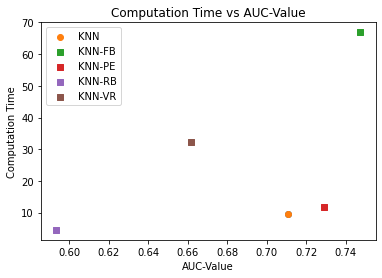

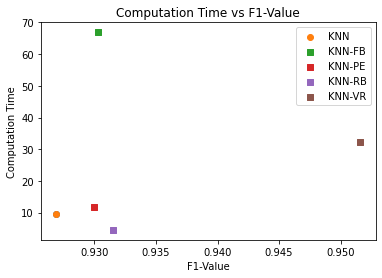

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


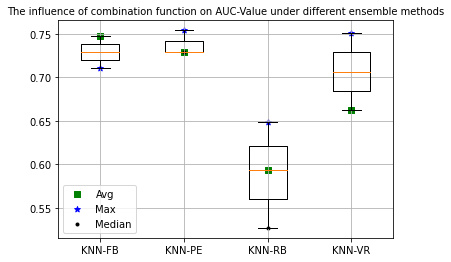

In [18]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_knn,auc_fb_knn, auc_pe_knn, auc_rb_knn , auc_vr_knn]
y = [time_test_knn,time_test_fb_knn, time_test_pe_knn, time_test_rb_knn, time_test_vr_knn]
ax.scatter(x, y)  
txt = ['KNN', 'KNN-FB',  'KNN-PE', 'KNN-RB', 'KNN-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_knn,f1_fb_knn, f1_pe_knn, f1_rb_knn , f1_vr_knn]
y = [time_test_knn,time_test_fb_knn, time_test_pe_knn, time_test_rb_knn, time_test_vr_knn]
ax.scatter(x, y)  
txt = ['KNN', 'KNN-FB',  'KNN-PE', 'KNN-RB', 'KNN-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='KNN-FB', "KNN-PE", 'KNN-RB','KNN-VR'

A = [auc_fb_knn,auc_fb1_knn]
B = [auc_pe_knn, auc_pe1_knn, auc_pe2_knn]
C = [auc_rb_knn, auc_rb1_knn, auc_rb2_knn]
D = [auc_vr_knn,auc_vr1_knn]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_knn,auc_pe_knn,auc_rb_knn,auc_vr_knn],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_knn,auc_pe1_knn,auc_rb1_knn,auc_vr1_knn],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_knn,auc_rb2_knn],label="Median",marker='.',c='k')

plt.legend()
plt.show()


In [19]:
#########################LOF
#lof
fpr_lof, tpr_lof, f1_lof, auc_lof,time_train_lof,time_test_lof, recall_lof, accuracy_lof=baseline(X_train, X_test, y_train, y_test,model="lof")


Base Detector:lof
Total time:  9.832985639572144 s.

Training set:

Confusion Matrix : 
 [[32992  3418]
 [  806   338]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36410
           1       0.09      0.30      0.14      1144

    accuracy                           0.89     37554
   macro avg       0.53      0.60      0.54     37554
weighted avg       0.95      0.89      0.92     37554

Area Under Curve : 
 0.6007896182367481

Test set:

Confusion Matrix : 
 [[32943  3465]
 [  782   365]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.90      0.94     36408
           1       0.10      0.32      0.15      1147

    accuracy                           0.89     37555
   macro avg       0.54      0.61      0.54     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.6115250281753035


In [20]:
#feature bagging
fpr_fb_lof, tpr_fb_lof, f1_fb_lof, auc_fb_lof,time_train_fb_lof,time_test_fb_lof, recall_fb_lof, accuracy_fb_lof=feature_bagging(X_train, X_test, y_train, y_test,basemodel="lof")


Feature Bagging:
Total time:  60.320454835891724 s.
training set:
Confusion Matrix : 
 [[33054  3356]
 [  744   400]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36410
           1       0.11      0.35      0.16      1144

    accuracy                           0.89     37554
   macro avg       0.54      0.63      0.55     37554
weighted avg       0.95      0.89      0.92     37554

Area Under Curve : 
 0.6287389347812309
test set:
Confusion Matrix : 
 [[32964  3444]
 [  723   424]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.11      0.37      0.17      1147

    accuracy                           0.89     37555
   macro avg       0.54      0.64      0.55     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.6375326939843068
f1: 0.916990294093437 auc: 0.63753

In [21]:
fpr_fb1_lof, tpr_fb1_lof, f1_fb1_lof, auc_fb1_lof,time_train_fb1_max_lof,time_test_fb1_max_lof, recall_fb1_lof, accuracy_fb1_lof=feature_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


Feature Bagging:
Total time:  57.9508798122406 s.
training set:
Confusion Matrix : 
 [[33025  3385]
 [  773   371]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36410
           1       0.10      0.32      0.15      1144

    accuracy                           0.89     37554
   macro avg       0.54      0.62      0.55     37554
weighted avg       0.95      0.89      0.92     37554

Area Under Curve : 
 0.6156658673652633
test set:
Confusion Matrix : 
 [[32958  3450]
 [  797   350]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.31      0.14      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.61      0.54     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.6051922299955345
f1: 0.9150980349791318 auc: 0.605192

In [22]:
#parameter ensemble
fpr_pe_lof, tpr_pe_lof, f1_pe_lof, auc_pe_lof,time_train_pe_lof,time_test_pe_lof, recall_pe_lof, accuracy_pe_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof")


parameter ensemble:
Confusion Matrix : 
 [[32943  3465]
 [  782   365]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.90      0.94     36408
           1       0.10      0.32      0.15      1147

    accuracy                           0.89     37555
   macro avg       0.54      0.61      0.54     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.6115250281753035
parameter ensemble:
Confusion Matrix : 
 [[32969  3439]
 [  792   355]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.31      0.14      1147

    accuracy                           0.89     37555
   macro avg       0.54      0.61      0.54     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.6075228946491731
parameter ensemble:
Confusion Matrix : 
 [[32978  3430]
 [  793   354]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [23]:
fpr_pe1_lof, tpr_pe1_lof, f1_pe1_lof, auc_pe1_lof,time_train_pe1_max_lof,time_test_pe1_max_lof, recall_pe1_lof, accuracy_pe1_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[32943  3465]
 [  782   365]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.90      0.94     36408
           1       0.10      0.32      0.15      1147

    accuracy                           0.89     37555
   macro avg       0.54      0.61      0.54     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.6115250281753035
parameter ensemble:
Confusion Matrix : 
 [[32969  3439]
 [  792   355]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.31      0.14      1147

    accuracy                           0.89     37555
   macro avg       0.54      0.61      0.54     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.6075228946491731
parameter ensemble:
Confusion Matrix : 
 [[32978  3430]
 [  793   354]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [24]:
fpr_pe2_lof, tpr_pe2_lof, f1_pe2_lof, auc_pe2_lof,time_train_pe2_median_lof,time_test_pe2_median_lof, recall_pe2_lof, accuracy_pe2_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[32943  3465]
 [  782   365]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.90      0.94     36408
           1       0.10      0.32      0.15      1147

    accuracy                           0.89     37555
   macro avg       0.54      0.61      0.54     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.6115250281753035
parameter ensemble:
Confusion Matrix : 
 [[32969  3439]
 [  792   355]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.31      0.14      1147

    accuracy                           0.89     37555
   macro avg       0.54      0.61      0.54     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.6075228946491731
parameter ensemble:
Confusion Matrix : 
 [[32978  3430]
 [  793   354]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [25]:
#rotated bagging
fpr_rb_lof, tpr_rb_lof, f1_rb_lof, auc_rb_lof,time_train_rb_lof,time_test_rb_lof, recall_rb_lof, accuracy_rb_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof",loop=20)


Confusion Matrix : 
 [[32043  4365]
 [  931   216]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.88      0.92     36408
           1       0.05      0.19      0.08      1147

    accuracy                           0.86     37555
   macro avg       0.51      0.53      0.50     37555
weighted avg       0.94      0.86      0.90     37555

Area Under Curve : 
 0.5342130584557807
Confusion Matrix : 
 [[31985  4423]
 [  966   181]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.88      0.92     36408
           1       0.04      0.16      0.06      1147

    accuracy                           0.86     37555
   macro avg       0.50      0.52      0.49     37555
weighted avg       0.94      0.86      0.90     37555

Area Under Curve : 
 0.5181593375436805
Confusion Matrix : 
 [[32010  4398]
 [  942   205]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[34866  1542]
 [  986   161]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.96      0.97     36408
           1       0.09      0.14      0.11      1147

    accuracy                           0.93     37555
   macro avg       0.53      0.55      0.54     37555
weighted avg       0.95      0.93      0.94     37555

Area Under Curve : 
 0.5490064218427712


In [26]:
fpr_rb1_lof, tpr_rb1_lof, f1_rb1_lof, auc_rb1_lof,time_train_rb1_max_lof,time_test_rb1_max_lof, recall_rb1_lof, accuracy_rb1_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max",loop=20)


Confusion Matrix : 
 [[32288  4120]
 [  872   275]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.89      0.93     36408
           1       0.06      0.24      0.10      1147

    accuracy                           0.87     37555
   macro avg       0.52      0.56      0.51     37555
weighted avg       0.95      0.87      0.90     37555

Area Under Curve : 
 0.56329697124347
Confusion Matrix : 
 [[32065  4343]
 [  900   247]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.88      0.92     36408
           1       0.05      0.22      0.09      1147

    accuracy                           0.86     37555
   macro avg       0.51      0.55      0.51     37555
weighted avg       0.94      0.86      0.90     37555

Area Under Curve : 
 0.5480287033689866
Confusion Matrix : 
 [[31623  4785]
 [  962   185]]
Classification Report : 
               precision    recall 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[17536 18872]
 [  340   807]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.48      0.65     36408
           1       0.04      0.70      0.08      1147

    accuracy                           0.49     37555
   macro avg       0.51      0.59      0.36     37555
weighted avg       0.95      0.49      0.63     37555

Area Under Curve : 
 0.5926134631878142


In [27]:
fpr_rb2_lof, tpr_rb2_lof, f1_rb2_lof, auc_rb2_lof,time_train_rb2_median_lof,time_test_rb2_median_lof, recall_rb2_lof, accuracy_rb2_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="median",loop=20)


Confusion Matrix : 
 [[31612  4796]
 [  974   173]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.87      0.92     36408
           1       0.03      0.15      0.06      1147

    accuracy                           0.85     37555
   macro avg       0.50      0.51      0.49     37555
weighted avg       0.94      0.85      0.89     37555

Area Under Curve : 
 0.5095494786682827
Confusion Matrix : 
 [[31755  4653]
 [  980   167]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.87      0.92     36408
           1       0.03      0.15      0.06      1147

    accuracy                           0.85     37555
   macro avg       0.50      0.51      0.49     37555
weighted avg       0.94      0.85      0.89     37555

Area Under Curve : 
 0.5088978140217322
Confusion Matrix : 
 [[31450  4958]
 [  988   159]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[36035   373]
 [ 1122    25]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     36408
           1       0.06      0.02      0.03      1147

    accuracy                           0.96     37555
   macro avg       0.52      0.51      0.51     37555
weighted avg       0.94      0.96      0.95     37555

Area Under Curve : 
 0.5057754942196326


In [28]:
#variable sampling with rotated bagging
fpr_vr_lof, tpr_vr_lof, f1_vr_lof, auc_vr_lof,time_train_vr_lof,time_test_vr_lof, recall_vr_lof, accuracy_vr_lof=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="lof", loop=100,mul=30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[35009  1401]
 [  943   201]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.96      0.97     36410
           1       0.13      0.18      0.15      1144

    accuracy                           0.94     37554
   macro avg       0.55      0.57      0.56     37554
weighted avg       0.95      0.94      0.94     37554

Area Under Curve : 
 0.5686104303551434
Confusion Matrix : 
 [[35001  1407]
 [  952   195]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.96      0.97     36408
           1       0.12      0.17      0.14      1147

    accuracy                           0.94     37555
   macro avg       0.55      0.57      0.55     37555
weighted avg       0.95      0.94      0.94     37555

Area Under Curve : 
 0.5656816828630361
VR Total time:  116.07807493209839 s.


In [29]:
fpr_vr1_lof, tpr_vr1_lof, f1_vr1_lof, auc_vr1_lof,time_train_vr1_max_lof,time_test_vr1_max_lof, recall_vr1_lof, accuracy_vr1_lof=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="lof",combination_function="max", loop=100,mul=30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[31453  4957]
 [  662   482]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.86      0.92     36410
           1       0.09      0.42      0.15      1144

    accuracy                           0.85     37554
   macro avg       0.53      0.64      0.53     37554
weighted avg       0.95      0.85      0.89     37554

Area Under Curve : 
 0.6425923774111085
Confusion Matrix : 
 [[31446  4962]
 [  637   510]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.86      0.92     36408
           1       0.09      0.44      0.15      1147

    accuracy                           0.85     37555
   macro avg       0.54      0.65      0.54     37555
weighted avg       0.95      0.85      0.89     37555

Area Under Curve : 
 0.6541747294107639
VR Total time:  115.06065845489502 s.


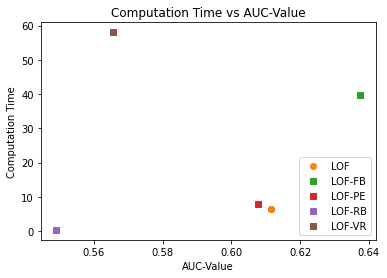

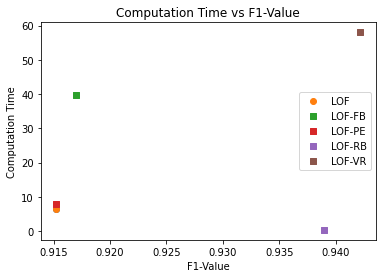

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


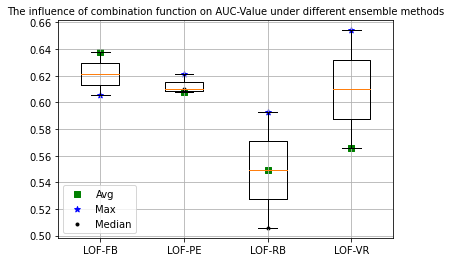

In [30]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_lof,auc_fb_lof, auc_pe_lof, auc_rb_lof , auc_vr_lof]
y = [time_test_lof,time_test_fb_lof, time_test_pe_lof, time_test_rb_lof, time_test_vr_lof]
ax.scatter(x, y)  
txt = ['LOF', 'LOF-FB',  'LOF-PE', 'LOF-RB', 'LOF-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_lof,f1_fb_lof, f1_pe_lof, f1_rb_lof , f1_vr_lof]
y = [time_test_lof,time_test_fb_lof, time_test_pe_lof, time_test_rb_lof, time_test_vr_lof]
ax.scatter(x, y)  
txt = ['LOF', 'LOF-FB',  'LOF-PE', 'LOF-RB', 'LOF-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='LOF-FB', "LOF-PE", 'LOF-RB','LOF-VR'
A = [auc_fb_lof,auc_fb1_lof]
B = [auc_pe_lof, auc_pe1_lof, auc_pe2_lof]
C = [auc_rb_lof, auc_rb1_lof, auc_rb2_lof]
D = [auc_vr_lof,auc_vr1_lof]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_lof,auc_pe_lof,auc_rb_lof,auc_vr_lof],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_lof,auc_pe1_lof,auc_rb1_lof,auc_vr1_lof],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_lof,auc_rb2_lof],label="Median",marker='.',c='k')

plt.legend()
plt.show()



In [31]:
##################################HBOS
#hbos
fpr_hbos, tpr_hbos, f1_hbos, auc_hbos,time_train_hbos,time_test_hbos, recall_hbos, accuracy_hbos=baseline(X_train, X_test, y_train, y_test,model="hbos")


Base Detector:hbos
Total time:  2.1380789279937744 s.

Training set:

Confusion Matrix : 
 [[32935  3475]
 [  863   281]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36410
           1       0.07      0.25      0.11      1144

    accuracy                           0.88     37554
   macro avg       0.52      0.58      0.53     37554
weighted avg       0.95      0.88      0.91     37554

Area Under Curve : 
 0.5750942788329495

Test set:

Confusion Matrix : 
 [[32907  3501]
 [  897   250]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.07      0.22      0.10      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.56      0.52     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.5608998554022159


In [32]:
#feature bagging
fpr_fb_hbos, tpr_fb_hbos, f1_fb_hbos, auc_fb_hbos,time_train_fb_hbos,time_test_fb_hbos, recall_fb_hbos, accuracy_fb_hbos=feature_bagging(X_train, X_test, y_train, y_test,basemodel="hbos")


Feature Bagging:
Total time:  0.4731099605560303 s.
training set:
Confusion Matrix : 
 [[32946  3464]
 [  852   292]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36410
           1       0.08      0.26      0.12      1144

    accuracy                           0.89     37554
   macro avg       0.53      0.58      0.53     37554
weighted avg       0.95      0.89      0.91     37554

Area Under Curve : 
 0.5800530285424546
test set:
Confusion Matrix : 
 [[32969  3439]
 [  904   243]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     36408
           1       0.07      0.21      0.10      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.56      0.52     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.5586998780842211
f1: 0.9126244553143416 auc: 0.5586

In [33]:
fpr_fb1_hbos, tpr_fb1_hbos, f1_fb1_hbos, auc_fb1_hbos,time_train_fb1_max_hbos,time_test_fb1_max_hbos, recall_fb1_hbos, accuracy_fb1_hbos=feature_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max")


Feature Bagging:
Total time:  0.5059671401977539 s.
training set:
Confusion Matrix : 
 [[32943  3467]
 [  857   287]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36410
           1       0.08      0.25      0.12      1144

    accuracy                           0.88     37554
   macro avg       0.53      0.58      0.53     37554
weighted avg       0.95      0.88      0.91     37554

Area Under Curve : 
 0.5778265163839181
test set:
Confusion Matrix : 
 [[32921  3487]
 [  895   252]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.07      0.22      0.10      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.56      0.52     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.5619639604199006
f1: 0.9121140826214696 auc: 0.5619

In [34]:
#parameter ensemble
fpr_pe_hbos, tpr_pe_hbos, f1_pe_hbos, auc_pe_hbos,time_train_pe_hbos,time_test_pe_hbos, recall_pe_hbos, accuracy_pe_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos",span=3)


parameter ensemble:
Confusion Matrix : 
 [[32907  3501]
 [  897   250]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.07      0.22      0.10      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.56      0.52     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.5608998554022159
parameter ensemble:
Confusion Matrix : 
 [[32903  3505]
 [  875   272]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.07      0.24      0.11      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.57      0.52     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.5704351578171405
parameter ensemble:
Confusion Matrix : 
 [[32909  3499]
 [  861   286]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [35]:
fpr_pe1_hbos, tpr_pe1_hbos, f1_pe1_hbos, auc_pe1_hbos,time_train_pe1_max_hbos,time_test_pe1_max_hbos, recall_pe1_hbos, accuracy_pe1_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max",span=3)


parameter ensemble:
Confusion Matrix : 
 [[32907  3501]
 [  897   250]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.07      0.22      0.10      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.56      0.52     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.5608998554022159
parameter ensemble:
Confusion Matrix : 
 [[32903  3505]
 [  875   272]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.07      0.24      0.11      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.57      0.52     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.5704351578171405
parameter ensemble:
Confusion Matrix : 
 [[32909  3499]
 [  861   286]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [36]:
fpr_pe2_hbos, tpr_pe2_hbos, f1_pe2_hbos, auc_pe2_hbos,time_train_pe2_median_hbos,time_test_pe2_median_hbos, recall_pe2_hbos, accuracy_pe2_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="median",span=3)


parameter ensemble:
Confusion Matrix : 
 [[32907  3501]
 [  897   250]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.07      0.22      0.10      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.56      0.52     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.5608998554022159
parameter ensemble:
Confusion Matrix : 
 [[32903  3505]
 [  875   272]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.07      0.24      0.11      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.57      0.52     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.5704351578171405
parameter ensemble:
Confusion Matrix : 
 [[32909  3499]
 [  861   286]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [37]:
#rotated bagging
fpr_rb_hbos, tpr_rb_hbos, f1_rb_hbos, auc_rb_hbos,time_train_rb_hbos,time_test_rb_hbos, recall_rb_hbos, accuracy_rb_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",loop=20)


Confusion Matrix : 
 [[32846  3562]
 [  998   149]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.04      0.13      0.06      1147

    accuracy                           0.88     37555
   macro avg       0.51      0.52      0.50     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.5160342285637328
Confusion Matrix : 
 [[33134  3274]
 [ 1046   101]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     36408
           1       0.03      0.09      0.04      1147

    accuracy                           0.88     37555
   macro avg       0.50      0.50      0.49     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.49906525329420687
Confusion Matrix : 
 [[33121  3287]
 [ 1041   106]]
Classification Report : 
               precision    reca

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[33045  3365]
 [ 1049    95]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     36410
           1       0.03      0.08      0.04      1144

    accuracy                           0.88     37554
   macro avg       0.50      0.50      0.49     37554
weighted avg       0.94      0.88      0.91     37554

Area Under Curve : 
 0.4953111465573702
test set:
Confusion Matrix : 
 [[34837  1571]
 [ 1099    48]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.96      0.96     36408
           1       0.03      0.04      0.03      1147

    accuracy                           0.93     37555
   macro avg       0.50      0.50      0.50     37555
weighted avg       0.94      0.93      0.93     37555

Area Under Curve : 
 0.4993492213692843


In [38]:
fpr_rb1_hbos, tpr_rb1_hbos, f1_rb1_hbos, auc_rb1_hbos,time_train_rb1_max_hbos,time_test_rb1_max_hbos, recall_rb1_hbos, accuracy_rb1_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max",loop=20)


Confusion Matrix : 
 [[32947  3461]
 [  911   236]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.06      0.21      0.10      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.56      0.52     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.5553463081492193
Confusion Matrix : 
 [[32954  3454]
 [ 1000   147]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     36408
           1       0.04      0.13      0.06      1147

    accuracy                           0.88     37555
   macro avg       0.51      0.52      0.50     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.5166455794897966
Confusion Matrix : 
 [[33104  3304]
 [ 1031   116]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[32875  3535]
 [ 1014   130]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36410
           1       0.04      0.11      0.05      1144

    accuracy                           0.88     37554
   macro avg       0.50      0.51      0.49     37554
weighted avg       0.94      0.88      0.91     37554

Area Under Curve : 
 0.5082738258720132
test set:
Confusion Matrix : 
 [[23545 12863]
 [  399   748]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.65      0.78     36408
           1       0.05      0.65      0.10      1147

    accuracy                           0.65     37555
   macro avg       0.52      0.65      0.44     37555
weighted avg       0.95      0.65      0.76     37555

Area Under Curve : 
 0.6494172673854027


In [39]:
fpr_rb2_hbos, tpr_rb2_hbos, f1_rb2_hbos, auc_rb2_hbos,time_train_rb2_median_hbos,time_test_rb2_median_hbos, recall_rb2_hbos, accuracy_rb2_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="median",loop=20)


Confusion Matrix : 
 [[33276  3132]
 [ 1073    74]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     36408
           1       0.02      0.06      0.03      1147

    accuracy                           0.89     37555
   macro avg       0.50      0.49      0.49     37555
weighted avg       0.94      0.89      0.91     37555

Area Under Curve : 
 0.4892455397962872
Confusion Matrix : 
 [[33400  3008]
 [ 1051    96]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     36408
           1       0.03      0.08      0.05      1147

    accuracy                           0.89     37555
   macro avg       0.50      0.50      0.49     37555
weighted avg       0.94      0.89      0.92     37555

Area Under Curve : 
 0.500538697627604
Confusion Matrix : 
 [[32892  3516]
 [ 1027   120]]
Classification Report : 
               precision    recall

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


training set:
Confusion Matrix : 
 [[33297  3113]
 [ 1046    98]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     36410
           1       0.03      0.09      0.05      1144

    accuracy                           0.89     37554
   macro avg       0.50      0.50      0.49     37554
weighted avg       0.94      0.89      0.91     37554

Area Under Curve : 
 0.5000829231191769
test set:
Confusion Matrix : 
 [[34755  1653]
 [ 1093    54]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     36408
           1       0.03      0.05      0.04      1147

    accuracy                           0.93     37555
   macro avg       0.50      0.50      0.50     37555
weighted avg       0.94      0.93      0.93     37555

Area Under Curve : 
 0.5008386139877091


In [40]:
#variable sampling with rotated bagging
fpr_vr_hbos, tpr_vr_hbos, f1_vr_hbos, auc_vr_hbos,time_train_vr_hbos,time_test_vr_hbos, recall_vr_hbos, accuracy_vr_hbos=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="hbos",threshold=0,loop=100,mul=30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[18721 17689]
 [  349   795]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.51      0.67     36410
           1       0.04      0.69      0.08      1144

    accuracy                           0.52     37554
   macro avg       0.51      0.60      0.38     37554
weighted avg       0.95      0.52      0.66     37554

Area Under Curve : 
 0.6045510003591574
Confusion Matrix : 
 [[18571 17837]
 [  398   749]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.51      0.67     36408
           1       0.04      0.65      0.08      1147

    accuracy                           0.51     37555
   macro avg       0.51      0.58      0.37     37555
weighted avg       0.95      0.51      0.65     37555

Area Under Curve : 
 0.5815440243548032
VR Total time:  3.416826009750366 s.


In [41]:
fpr_vr1_hbos, tpr_vr1_hbos, f1_vr1_hbos, auc_vr1_hbos,time_train_vr1_max_hbos,time_test_vr1_max_hbos, recall_vr1_hbos, accuracy_vr1_hbos=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="hbos",combination_function="max",threshold=0,loop=100,mul=30)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[14175 22235]
 [  208   936]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.39      0.56     36410
           1       0.04      0.82      0.08      1144

    accuracy                           0.40     37554
   macro avg       0.51      0.60      0.32     37554
weighted avg       0.96      0.40      0.54     37554

Area Under Curve : 
 0.6037489700631695
Confusion Matrix : 
 [[14055 22353]
 [  251   896]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.39      0.55     36408
           1       0.04      0.78      0.07      1147

    accuracy                           0.40     37555
   macro avg       0.51      0.58      0.31     37555
weighted avg       0.95      0.40      0.54     37555

Area Under Curve : 
 0.5836048971867225
VR Total time:  3.4563021659851074 s.


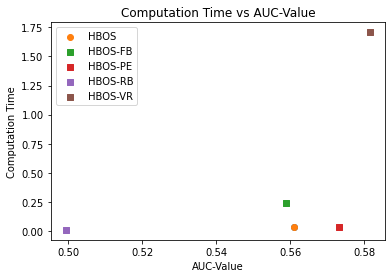

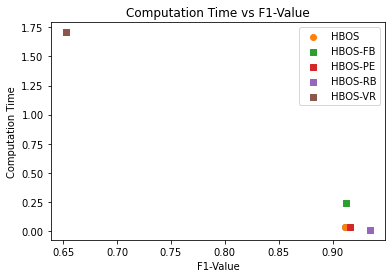

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


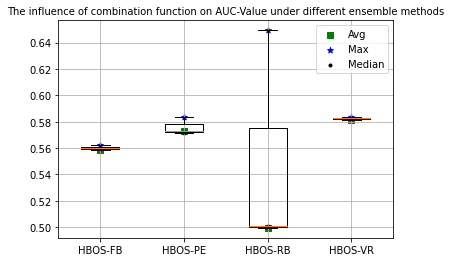

In [42]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_hbos,auc_fb_hbos, auc_pe_hbos, auc_rb_hbos , auc_vr_hbos]
y = [time_test_hbos,time_test_fb_hbos, time_test_pe_hbos, time_test_rb_hbos, time_test_vr_hbos]
ax.scatter(x, y)  
txt = ['HBOS', 'HBOS-FB',  'HBOS-PE', 'HBOS-RB', 'HBOS-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_hbos,f1_fb_hbos, f1_pe_hbos, f1_rb_hbos , f1_vr_hbos]
y = [time_test_hbos,time_test_fb_hbos, time_test_pe_hbos, time_test_rb_hbos, time_test_vr_hbos]
ax.scatter(x, y)  
txt = ['HBOS', 'HBOS-FB',  'HBOS-PE', 'HBOS-RB', 'HBOS-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()
#######

labels ='HBOS-FB', "HBOS-PE", 'HBOS-RB','HBOS-VR'
A = [auc_fb_hbos,auc_fb1_hbos]
B = [auc_pe_hbos, auc_pe1_hbos, auc_pe2_hbos]
C = [auc_rb_hbos, auc_rb1_hbos, auc_rb2_hbos]
D = [auc_vr_hbos,auc_vr1_hbos]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_hbos,auc_pe_hbos,auc_rb_hbos,auc_vr_hbos],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_hbos,auc_pe1_hbos,auc_rb1_hbos,auc_vr1_hbos],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_hbos,auc_rb2_hbos],label="Median",marker='.',c='k')
plt.legend()
plt.show()

In [43]:
# ##################################One-Class SVM
#ocsvm
fpr_ocsvm, tpr_ocsvm, f1_ocsvm, auc_ocsvm,time_train_ocsvm,time_test_ocsvm, recall_ocsvm, accuracy_ocsvm =baseline(X_train, X_test, y_train, y_test,model="ocsvm")


Base Detector:ocsvm
Total time:  216.72865772247314 s.

Training set:

Confusion Matrix : 
 [[32996  3414]
 [  802   342]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36410
           1       0.09      0.30      0.14      1144

    accuracy                           0.89     37554
   macro avg       0.53      0.60      0.54     37554
weighted avg       0.95      0.89      0.92     37554

Area Under Curve : 
 0.6025927999492954

Test set:

Confusion Matrix : 
 [[33023  3385]
 [  832   315]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.27      0.13      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.59      0.53     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.5908276982726235


In [44]:
#feature bagging
fpr_fb_ocsvm, tpr_fb_ocsvm, f1_fb_ocsvm, auc_fb_ocsvm,time_train_fb_ocsvm,time_test_fb_ocsvm, recall_fb_ocsvm, accuracy_fb_ocsvm =feature_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm")


Feature Bagging:
Total time:  1985.8625342845917 s.
training set:
Confusion Matrix : 
 [[32983  3427]
 [  815   329]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36410
           1       0.09      0.29      0.13      1144

    accuracy                           0.89     37554
   macro avg       0.53      0.60      0.54     37554
weighted avg       0.95      0.89      0.92     37554

Area Under Curve : 
 0.5967324593835167
test set:
Confusion Matrix : 
 [[33007  3401]
 [  855   292]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     36408
           1       0.08      0.25      0.12      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.58      0.53     37555
weighted avg       0.95      0.89      0.91     37555

Area Under Curve : 
 0.580581811158129
f1: 0.9144267697169203 auc: 0.58058

In [45]:
fpr_fb1_ocsvm, tpr_fb1_ocsvm, f1_fb1_ocsvm, auc_fb1_ocsvm,time_train_fb1_max_ocsvm,time_test_fb1_max_ocsvm, recall_fb1_ocsvm, accuracy_fb1_ocsvm=feature_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max")


Feature Bagging:
Total time:  2055.245526075363 s.
training set:
Confusion Matrix : 
 [[33015  3395]
 [  783   361]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36410
           1       0.10      0.32      0.15      1144

    accuracy                           0.89     37554
   macro avg       0.54      0.61      0.54     37554
weighted avg       0.95      0.89      0.92     37554

Area Under Curve : 
 0.611157913083895
test set:
Confusion Matrix : 
 [[32989  3419]
 [  804   343]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.30      0.14      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.60      0.54     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.6025665220688824
f1: 0.9154075845929429 auc: 0.602566

In [46]:
#parameter ensemble
fpr_pe_ocsvm, tpr_pe_ocsvm, f1_pe_ocsvm, auc_pe_ocsvm,time_train_pe_ocsvm,time_test_pe_ocsvm, recall_pe_ocsvm, accuracy_pe_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm",span=3)


parameter ensemble:
Confusion Matrix : 
 [[33023  3385]
 [  832   315]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.27      0.13      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.59      0.53     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.5908276982726235
parameter ensemble:
Confusion Matrix : 
 [[33023  3385]
 [  832   315]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.27      0.13      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.59      0.53     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.5908276982726235
parameter ensemble:
Confusion Matrix : 
 [[33023  3385]
 [  832   315]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [47]:
fpr_pe1_ocsvm, tpr_pe1_ocsvm, f1_pe1_ocsvm, auc_pe1_ocsvm,time_train_pe1_max_ocsvm,time_test_pe1_max_ocsvm, recall_pe1_ocsvm, accuracy_pe1_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max",span=3)


parameter ensemble:
Confusion Matrix : 
 [[33023  3385]
 [  832   315]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.27      0.13      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.59      0.53     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.5908276982726235
parameter ensemble:
Confusion Matrix : 
 [[33023  3385]
 [  832   315]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.27      0.13      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.59      0.53     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.5908276982726235
parameter ensemble:
Confusion Matrix : 
 [[33023  3385]
 [  832   315]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [48]:
fpr_pe2_ocsvm, tpr_pe2_ocsvm, f1_pe2_ocsvm, auc_pe2_ocsvm,time_train_pe2_median_ocsvm,time_test_pe2_median_ocsvm, recall_pe2_ocsvm, accuracy_pe2_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="median",span=3)


parameter ensemble:
Confusion Matrix : 
 [[33023  3385]
 [  832   315]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.27      0.13      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.59      0.53     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.5908276982726235
parameter ensemble:
Confusion Matrix : 
 [[33023  3385]
 [  832   315]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.27      0.13      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.59      0.53     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.5908276982726235
parameter ensemble:
Confusion Matrix : 
 [[33023  3385]
 [  832   315]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [49]:
#rotated bagging
fpr_rb_ocsvm, tpr_rb_ocsvm, f1_rb_ocsvm, auc_rb_ocsvm,time_train_rb_ocsvm,time_test_rb_ocsvm, recall_rb_ocsvm, accuracy_rb_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",loop=20)


Confusion Matrix : 
 [[32776  3632]
 [ 1000   147]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93     36408
           1       0.04      0.13      0.06      1147

    accuracy                           0.88     37555
   macro avg       0.50      0.51      0.50     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.5142010618013766
Confusion Matrix : 
 [[32828  3580]
 [  936   211]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.06      0.18      0.09      1147

    accuracy                           0.88     37555
   macro avg       0.51      0.54      0.51     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.5428140571728298
Confusion Matrix : 
 [[32779  3629]
 [ 1044   103]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[34160  2248]
 [ 1056    91]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.94      0.95     36408
           1       0.04      0.08      0.05      1147

    accuracy                           0.91     37555
   macro avg       0.50      0.51      0.50     37555
weighted avg       0.94      0.91      0.93     37555

Area Under Curve : 
 0.508796365208639


In [50]:
fpr_rb1_ocsvm, tpr_rb1_ocsvm, f1_rb1_ocsvm, auc_rb1_ocsvm,time_train_rb1_max_ocsvm,time_test_rb1_max_ocsvm, recall_rb1_ocsvm, accuracy_rb1_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max",loop=20)


Confusion Matrix : 
 [[32800  3608]
 [ 1080    67]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93     36408
           1       0.02      0.06      0.03      1147

    accuracy                           0.88     37555
   macro avg       0.49      0.48      0.48     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.47965707643127004
Confusion Matrix : 
 [[32733  3675]
 [ 1041   106]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93     36408
           1       0.03      0.09      0.04      1147

    accuracy                           0.87     37555
   macro avg       0.50      0.50      0.49     37555
weighted avg       0.94      0.87      0.91     37555

Area Under Curve : 
 0.4957378208263338
Confusion Matrix : 
 [[32940  3468]
 [  986   161]]
Classification Report : 
               precision    reca

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[22436 13972]
 [  496   651]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.62      0.76     36408
           1       0.04      0.57      0.08      1147

    accuracy                           0.61     37555
   macro avg       0.51      0.59      0.42     37555
weighted avg       0.95      0.61      0.74     37555

Area Under Curve : 
 0.5919028784882443


In [51]:
fpr_rb2_ocsvm, tpr_rb2_ocsvm, f1_rb2_ocsvm, auc_rb2_ocsvm,time_train_rb2_median_ocsvm,time_test_rb2_median_ocsvm, recall_rb2_ocsvm, accuracy_rb2_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="median",loop=20)


Confusion Matrix : 
 [[32833  3575]
 [ 1024   123]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93     36408
           1       0.03      0.11      0.05      1147

    accuracy                           0.88     37555
   macro avg       0.50      0.50      0.49     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.5045217818132846
Confusion Matrix : 
 [[32839  3569]
 [  977   170]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.05      0.15      0.07      1147

    accuracy                           0.88     37555
   macro avg       0.51      0.53      0.50     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.5250924114515775
Confusion Matrix : 
 [[32810  3598]
 [ 1044   103]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[34537  1871]
 [ 1110    37]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     36408
           1       0.02      0.03      0.02      1147

    accuracy                           0.92     37555
   macro avg       0.49      0.49      0.49     37555
weighted avg       0.94      0.92      0.93     37555

Area Under Curve : 
 0.490434130038772


In [52]:
#variable sampling with rotated bagging
fpr_vr_ocsvm, tpr_vr_ocsvm, f1_vr_ocsvm, auc_vr_ocsvm,time_train_vr_ocsvm,time_test_vr_ocsvm, recall_vr_ocsvm, accuracy_vr_ocsvm=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="ocsvm",threshold=1.2,loop=80,mul=20)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[32588  3822]
 [  778   366]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.90      0.93     36410
           1       0.09      0.32      0.14      1144

    accuracy                           0.88     37554
   macro avg       0.53      0.61      0.54     37554
weighted avg       0.95      0.88      0.91     37554

Area Under Curve : 
 0.6074794540806625
Confusion Matrix : 
 [[32635  3773]
 [  805   342]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.90      0.93     36408
           1       0.08      0.30      0.13      1147

    accuracy                           0.88     37555
   macro avg       0.53      0.60      0.53     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.5972690333921647
VR Total time:  883.7228782176971 s.


In [53]:
fpr_vr1_ocsvm, tpr_vr1_ocsvm, f1_vr1_ocsvm, auc_vr1_ocsvm,time_train_vr1_max_ocsvm,time_test_vr1_max_ocsvm, recall_vr1_ocsvm, accuracy_vr1_ocsvm=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="ocsvm",combination_function="max",threshold=1.2,loop=80,mul=20)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[32304  4106]
 [  764   380]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.89      0.93     36410
           1       0.08      0.33      0.13      1144

    accuracy                           0.87     37554
   macro avg       0.53      0.61      0.53     37554
weighted avg       0.95      0.87      0.91     37554

Area Under Curve : 
 0.6096983077345615
Confusion Matrix : 
 [[32369  4039]
 [  797   350]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.89      0.93     36408
           1       0.08      0.31      0.13      1147

    accuracy                           0.87     37555
   macro avg       0.53      0.60      0.53     37555
weighted avg       0.95      0.87      0.91     37555

Area Under Curve : 
 0.5971033484310432
VR Total time:  785.1726937294006 s.


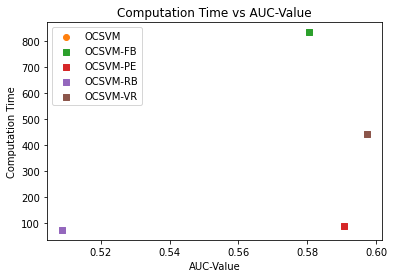

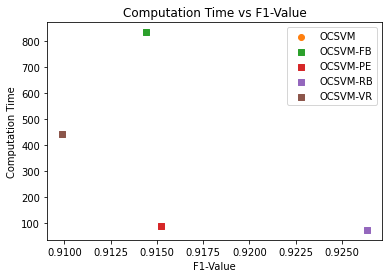

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


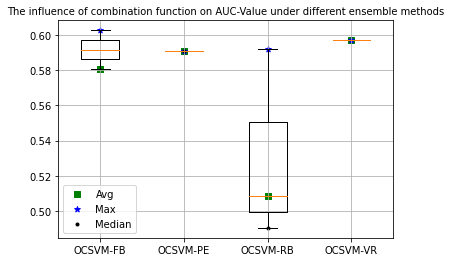

In [54]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_ocsvm,auc_fb_ocsvm, auc_pe_ocsvm, auc_rb_ocsvm , auc_vr_ocsvm]
y = [time_test_ocsvm,time_test_fb_ocsvm, time_test_pe_ocsvm, time_test_rb_ocsvm, time_test_vr_ocsvm]
ax.scatter(x, y)  
txt = ['OCSVM', 'OCSVM-FB',  'OCSVM-PE', 'OCSVM-RB', 'OCSVM-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_ocsvm,f1_fb_ocsvm, f1_pe_ocsvm, f1_rb_ocsvm , f1_vr_ocsvm]
y = [time_test_ocsvm,time_test_fb_ocsvm, time_test_pe_ocsvm, time_test_rb_ocsvm, time_test_vr_ocsvm]
ax.scatter(x, y)  
txt = ['OCSVM', 'OCSVM-FB',  'OCSVM-PE', 'OCSVM-RB', 'OCSVM-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='OCSVM-FB', "OCSVM-PE", 'OCSVM-RB','OCSVM-VR'

A = [auc_fb_ocsvm,auc_fb1_ocsvm]
B = [auc_pe_ocsvm, auc_pe1_ocsvm, auc_pe2_ocsvm]
C = [auc_rb_ocsvm, auc_rb1_ocsvm, auc_rb2_ocsvm]
D = [auc_vr_ocsvm,auc_vr1_ocsvm]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_ocsvm,auc_pe_ocsvm,auc_rb_ocsvm,auc_vr_ocsvm],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_ocsvm,auc_pe1_ocsvm,auc_rb1_ocsvm,auc_vr1_ocsvm],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_ocsvm,auc_rb2_ocsvm],label="Median",marker='.',c='k')
#
plt.legend()
plt.show()


In [55]:
##################################IForest
#iforest
fpr_ifo, tpr_ifo, f1_ifo, auc_ifo,time_train_ifo,time_test_ifo,recall_ifo, accuracy_ifo =baseline(X_train, X_test, y_train, y_test,model="iforest")


Base Detector:iforest
Total time:  5.581971883773804 s.

Training set:

Confusion Matrix : 
 [[33017  3393]
 [  781   363]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36410
           1       0.10      0.32      0.15      1144

    accuracy                           0.89     37554
   macro avg       0.54      0.61      0.54     37554
weighted avg       0.95      0.89      0.92     37554

Area Under Curve : 
 0.6120595039401686

Test set:

Confusion Matrix : 
 [[33121  3287]
 [  815   332]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.29      0.14      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.60      0.54     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.5995841927686931


In [56]:
#feature bagging
fpr_fb_ifo, tpr_fb_ifo, f1_fb_ifo, auc_fb_ifo,time_train_fb_ifo,time_test_fb_ifo,recall_fb_ifo, accuracy_fb_ifo=feature_bagging(X_train, X_test, y_train, y_test,basemodel="iforest")


Feature Bagging:
Total time:  50.60361170768738 s.
training set:
Confusion Matrix : 
 [[32870  3540]
 [  928   216]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36410
           1       0.06      0.19      0.09      1144

    accuracy                           0.88     37554
   macro avg       0.52      0.55      0.51     37554
weighted avg       0.94      0.88      0.91     37554

Area Under Curve : 
 0.5457925760040564
test set:
Confusion Matrix : 
 [[32952  3456]
 [  948   199]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     36408
           1       0.05      0.17      0.08      1147

    accuracy                           0.88     37555
   macro avg       0.51      0.54      0.51     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.5392859421183576
f1: 0.9112639304163135 auc: 0.53928

In [57]:
fpr_fb1_ifo, tpr_fb1_ifo, f1_fb1_ifo, auc_fb1_ifo,time_train_fb1_max_ifo,time_test_fb1_max_ifo,recall_fb1_ifo, accuracy_fb1_ifo=feature_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


Feature Bagging:
Total time:  50.63654971122742 s.
training set:
Confusion Matrix : 
 [[33080  3330]
 [  718   426]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36410
           1       0.11      0.37      0.17      1144

    accuracy                           0.89     37554
   macro avg       0.55      0.64      0.56     37554
weighted avg       0.95      0.89      0.92     37554

Area Under Curve : 
 0.6404596159127882
test set:
Confusion Matrix : 
 [[33095  3313]
 [  788   359]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.10      0.31      0.15      1147

    accuracy                           0.89     37555
   macro avg       0.54      0.61      0.55     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.6109969627377181
f1: 0.9174474068727719 auc: 0.61099

In [58]:
#parameter ensemble
fpr_pe_ifo, tpr_pe_ifo, f1_pe_ifo, auc_pe_ifo,time_train_pe_ifo,time_test_pe_ifo,recall_pe_ifo, accuracy_pe_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest")


parameter ensemble:
Confusion Matrix : 
 [[32951  3457]
 [  900   247]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     36408
           1       0.07      0.22      0.10      1147

    accuracy                           0.88     37555
   macro avg       0.52      0.56      0.52     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.560196358829325
parameter ensemble:
Confusion Matrix : 
 [[33051  3357]
 [  867   280]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     36408
           1       0.08      0.24      0.12      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.58      0.53     37555
weighted avg       0.95      0.89      0.91     37555

Area Under Curve : 
 0.5759550364684117
parameter ensemble:
Confusion Matrix : 
 [[33000  3408]
 [  881   266]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [59]:
fpr_pe1_ifo, tpr_pe1_ifo, f1_pe1_ifo, auc_pe1_ifo,time_train_pe1_max_ifo,time_test_pe1_max_ifo,recall_pe1_ifo, accuracy_pe1_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[33153  3255]
 [  826   321]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.28      0.14      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.60      0.54     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.5952285389244476
parameter ensemble:
Confusion Matrix : 
 [[33093  3315]
 [  841   306]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.08      0.27      0.13      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.59      0.53     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.5878657473366363
parameter ensemble:
Confusion Matrix : 
 [[33097  3311]
 [  845   302]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [60]:
fpr_pe2_ifo, tpr_pe2_ifo, f1_pe2_ifo, auc_pe2_ifo,time_train_pe2_median_ifo,time_test_pe2_median_ifo,recall_pe2_ifo, accuracy_pe2_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[33053  3355]
 [  815   332]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.09      0.29      0.14      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.60      0.54     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.5986503320787349
parameter ensemble:
Confusion Matrix : 
 [[33074  3334]
 [  847   300]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     36408
           1       0.08      0.26      0.13      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.58      0.53     37555
weighted avg       0.95      0.89      0.92     37555

Area Under Curve : 
 0.5849892969287147
parameter ensemble:
Confusion Matrix : 
 [[33046  3362]
 [  867   280]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [61]:
#rotated bagging
fpr_rb_ifo, tpr_rb_ifo, f1_rb_ifo, auc_rb_ifo,time_train_rb_ifo,time_test_rb_ifo,recall_rb_ifo, accuracy_rb_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",loop=20)


Confusion Matrix : 
 [[32879  3529]
 [ 1035   112]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.03      0.10      0.05      1147

    accuracy                           0.88     37555
   macro avg       0.50      0.50      0.49     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.5003583934052069
Confusion Matrix : 
 [[32834  3574]
 [  970   177]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.05      0.15      0.07      1147

    accuracy                           0.88     37555
   macro avg       0.51      0.53      0.50     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.5280751837596841
Confusion Matrix : 
 [[32754  3654]
 [ 1023   124]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[34538  1870]
 [ 1058    89]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     36408
           1       0.05      0.08      0.06      1147

    accuracy                           0.92     37555
   macro avg       0.51      0.51      0.51     37555
weighted avg       0.94      0.92      0.93     37555

Area Under Curve : 
 0.5131156924036545


In [62]:
fpr_rb1_ifo, tpr_rb1_ifo, f1_rb1_ifo, auc_rb1_ifo,time_train_rb1_max_ifo,time_test_rb1_max_ifo,recall_rb1_ifo, accuracy_rb1_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max",loop=20)


Confusion Matrix : 
 [[32708  3700]
 [ 1009   138]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93     36408
           1       0.04      0.12      0.06      1147

    accuracy                           0.87     37555
   macro avg       0.50      0.51      0.49     37555
weighted avg       0.94      0.87      0.91     37555

Area Under Curve : 
 0.5093439229945917
Confusion Matrix : 
 [[32832  3576]
 [ 1059    88]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93     36408
           1       0.02      0.08      0.04      1147

    accuracy                           0.88     37555
   macro avg       0.50      0.49      0.49     37555
weighted avg       0.94      0.88      0.91     37555

Area Under Curve : 
 0.4892508558912965
Confusion Matrix : 
 [[32836  3572]
 [  985   162]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[22379 14029]
 [  467   680]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.61      0.76     36408
           1       0.05      0.59      0.09      1147

    accuracy                           0.61     37555
   macro avg       0.51      0.60      0.42     37555
weighted avg       0.95      0.61      0.73     37555

Area Under Curve : 
 0.6037617574301288


In [63]:
fpr_rb2_ifo, tpr_rb2_ifo, f1_rb2_ifo, auc_rb2_ifo,time_train_rb2_median_ifo,time_test_rb2_median_ifo,recall_rb2_ifo, accuracy_rb2_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="median",loop=20)


Confusion Matrix : 
 [[32920  3488]
 [  851   296]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     36408
           1       0.08      0.26      0.12      1147

    accuracy                           0.88     37555
   macro avg       0.53      0.58      0.53     37555
weighted avg       0.95      0.88      0.91     37555

Area Under Curve : 
 0.5811306979678341
Confusion Matrix : 
 [[33023  3385]
 [  869   278]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     36408
           1       0.08      0.24      0.12      1147

    accuracy                           0.89     37555
   macro avg       0.53      0.57      0.53     37555
weighted avg       0.95      0.89      0.91     37555

Area Under Curve : 
 0.574698666014559
Confusion Matrix : 
 [[32821  3587]
 [ 1081    66]]
Classification Report : 
               precision    recall

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[34598  1810]
 [ 1077    70]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     36408
           1       0.04      0.06      0.05      1147

    accuracy                           0.92     37555
   macro avg       0.50      0.51      0.50     37555
weighted avg       0.94      0.92      0.93     37555

Area Under Curve : 
 0.5056572111056769


In [64]:
#variable sampling with rotated bagging
fpr_vr_ifo, tpr_vr_ifo, f1_vr_ifo, auc_vr_ifo,time_train_vr_ifo,time_test_vr_ifo,recall_vr_ifo, accuracy_vr_ifo=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="iforest",threshold=1.2,loop=100,mul=30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[31963  4447]
 [  736   408]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.88      0.93     36410
           1       0.08      0.36      0.14      1144

    accuracy                           0.86     37554
   macro avg       0.53      0.62      0.53     37554
weighted avg       0.95      0.86      0.90     37554

Area Under Curve : 
 0.6172532905161304
Confusion Matrix : 
 [[32056  4352]
 [  785   362]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.88      0.93     36408
           1       0.08      0.32      0.12      1147

    accuracy                           0.86     37555
   macro avg       0.53      0.60      0.52     37555
weighted avg       0.95      0.86      0.90     37555

Area Under Curve : 
 0.5980358800972492
VR Total time:  130.94434762001038 s.


In [65]:
fpr_vr1_ifo, tpr_vr1_ifo, f1_vr1_ifo, auc_vr1_ifo,time_train_vr1_max_ifo,time_test_vr1_max_ifo,recall_vr1_ifo, accuracy_vr1_ifo=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="iforest",combination_function="max",threshold=1.2,loop=100,mul=30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[28100  8310]
 [  501   643]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.77      0.86     36410
           1       0.07      0.56      0.13      1144

    accuracy                           0.77     37554
   macro avg       0.53      0.67      0.50     37554
weighted avg       0.95      0.77      0.84     37554

Area Under Curve : 
 0.666914467707519
Confusion Matrix : 
 [[28097  8311]
 [  551   596]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.77      0.86     36408
           1       0.07      0.52      0.12      1147

    accuracy                           0.76     37555
   macro avg       0.52      0.65      0.49     37555
weighted avg       0.95      0.76      0.84     37555

Area Under Curve : 
 0.6456711924355513
VR Total time:  135.49657034873962 s.


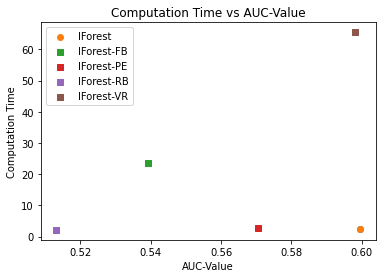

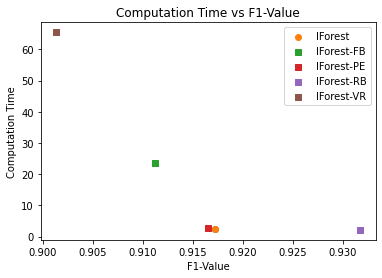

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


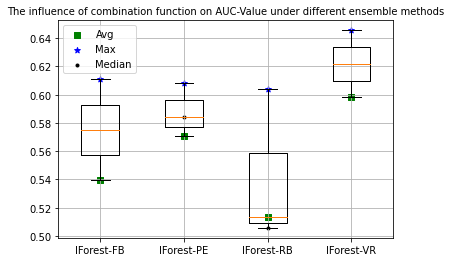

In [66]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_ifo,auc_fb_ifo, auc_pe_ifo, auc_rb_ifo , auc_vr_ifo]
y = [time_test_ifo,time_test_fb_ifo, time_test_pe_ifo, time_test_rb_ifo, time_test_vr_ifo]
ax.scatter(x, y)  
txt = ['IForest', 'IForest-FB',  'IForest-PE', 'IForest-RB', 'IForest-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_ifo,f1_fb_ifo, f1_pe_ifo, f1_rb_ifo , f1_vr_ifo]
y = [time_test_ifo,time_test_fb_ifo, time_test_pe_ifo, time_test_rb_ifo, time_test_vr_ifo]
ax.scatter(x, y)  
txt = ['IForest', 'IForest-FB',  'IForest-PE', 'IForest-RB', 'IForest-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='IForest-FB', "IForest-PE", 'IForest-RB','IForest-VR'

A = [auc_fb_ifo,auc_fb1_ifo]
B = [auc_pe_ifo, auc_pe1_ifo, auc_pe2_ifo]
C = [auc_rb_ifo, auc_rb1_ifo, auc_rb2_ifo]
D = [auc_vr_ifo,auc_vr1_ifo]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_ifo,auc_pe_ifo,auc_rb_ifo,auc_vr_ifo],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_ifo,auc_pe1_ifo,auc_rb1_ifo,auc_vr1_ifo],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_ifo,auc_rb2_ifo],label="Median",marker='.',c='k')

plt.legend()
plt.show()


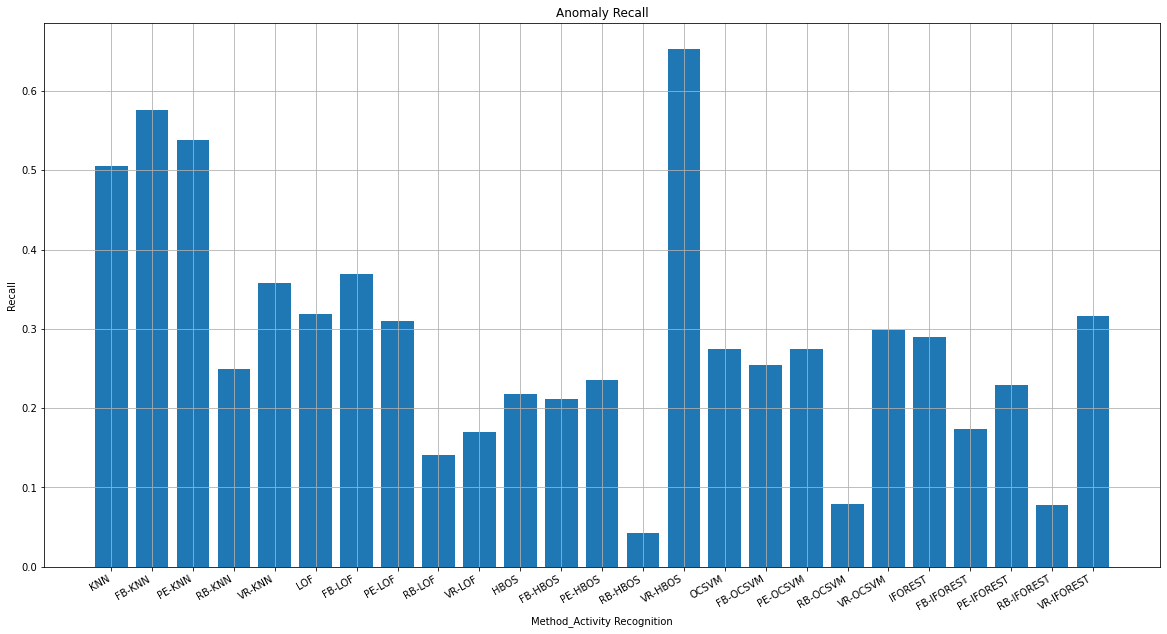

In [67]:
## recall ##
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


y = [recall_knn,recall_fb_knn,recall_pe_knn,recall_rb_knn,recall_vr_knn,
     recall_lof,recall_fb_lof,recall_pe_lof,recall_rb_lof,recall_vr_lof,
     recall_hbos,recall_fb_hbos,recall_pe_hbos,recall_rb_hbos,recall_vr_hbos,
     recall_ocsvm,recall_fb_ocsvm,recall_pe_ocsvm,recall_rb_ocsvm,recall_vr_ocsvm,
     recall_ifo,recall_fb_ifo,recall_pe_ifo,recall_rb_ifo,recall_vr_ifo]
x = ['KNN','FB-KNN','PE-KNN','RB-KNN','VR-KNN',
     'LOF','FB-LOF','PE-LOF','RB-LOF','VR-LOF',
     'HBOS','FB-HBOS','PE-HBOS','RB-HBOS','VR-HBOS',
     'OCSVM','FB-OCSVM','PE-OCSVM','RB-OCSVM','VR-OCSVM',
     'IFOREST','FB-IFOREST','PE-IFOREST','RB-IFOREST','VR-IFOREST']
ax= plt.subplot()
fig = plt.bar(x,y)
#plt.xticks(x,y)
plt.title("Anomaly Recall")
plt.xlabel("Method_Activity Recognition")
plt.ylabel("Recall")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.grid()
plt.show()




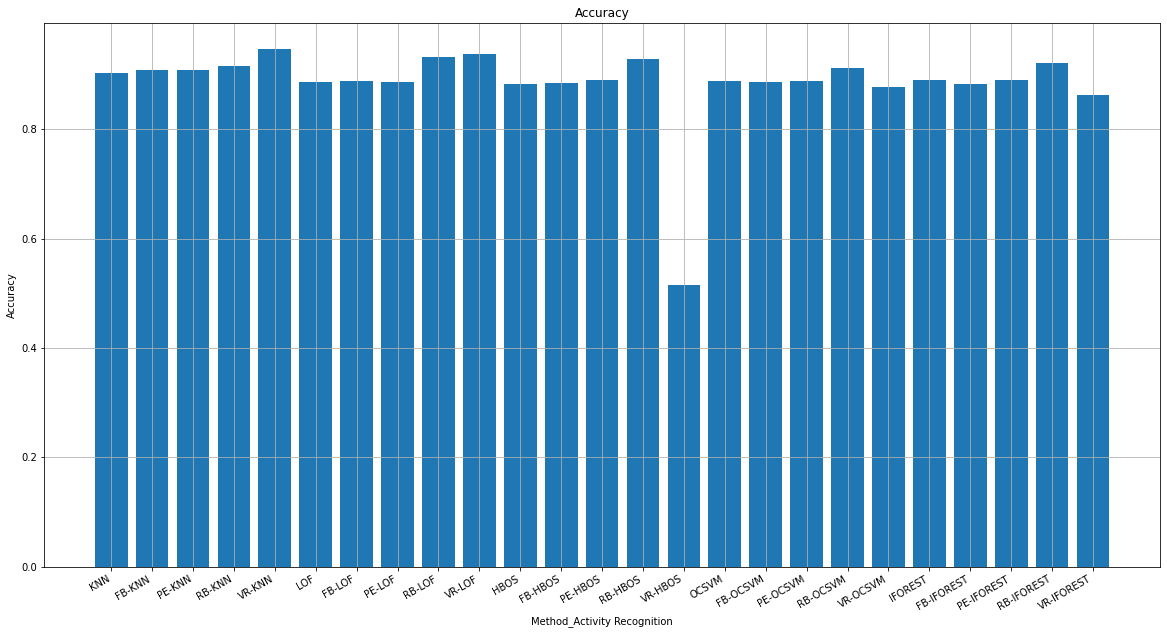

In [68]:
## Accuracy ##
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


y = [accuracy_knn,accuracy_fb_knn,accuracy_pe_knn,accuracy_rb_knn,accuracy_vr_knn,
     accuracy_lof,accuracy_fb_lof,accuracy_pe_lof,accuracy_rb_lof,accuracy_vr_lof,
     accuracy_hbos,accuracy_fb_hbos,accuracy_pe_hbos,accuracy_rb_hbos,accuracy_vr_hbos,
     accuracy_ocsvm,accuracy_fb_ocsvm,accuracy_pe_ocsvm,accuracy_rb_ocsvm,accuracy_vr_ocsvm,
     accuracy_ifo,accuracy_fb_ifo,accuracy_pe_ifo,accuracy_rb_ifo,accuracy_vr_ifo]
x = ['KNN','FB-KNN','PE-KNN','RB-KNN','VR-KNN',
     'LOF','FB-LOF','PE-LOF','RB-LOF','VR-LOF',
     'HBOS','FB-HBOS','PE-HBOS','RB-HBOS','VR-HBOS',
     'OCSVM','FB-OCSVM','PE-OCSVM','RB-OCSVM','VR-OCSVM',
     'IFOREST','FB-IFOREST','PE-IFOREST','RB-IFOREST','VR-IFOREST']

ax= plt.subplot()
fig = plt.bar(x,y)
#plt.xticks(x,y)
plt.title("Accuracy")
plt.xlabel("Method_Activity Recognition")
plt.ylabel("Accuracy")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.grid()
plt.show()

In [69]:
model_performance = pd.DataFrame(columns=['Accuracy','Recall','AUC','F1-Score','total time'])

model_performance.loc['KNN'] = [accuracy_knn, recall_knn, auc_knn, f1_knn,time_test_knn+time_train_knn]
model_performance.loc['FB-KNN_MEAN'] = [accuracy_fb_knn, recall_fb_knn, auc_fb_knn, f1_fb_knn,time_test_fb_knn+time_train_fb_knn]
model_performance.loc['FB-KNN_MAX'] = [accuracy_fb1_knn, recall_fb1_knn, auc_fb1_knn, f1_fb1_knn,time_test_fb1_max_knn+time_train_fb1_max_knn]
model_performance.loc['PE-KNN_MEAN'] = [accuracy_pe_knn, recall_pe_knn, auc_pe_knn, f1_pe_knn,time_test_pe_knn+time_train_pe_knn]
model_performance.loc['PE-KNN_MAX'] = [accuracy_pe1_knn, recall_pe1_knn, auc_pe1_knn, f1_pe1_knn,time_test_pe1_max_knn+time_train_pe1_max_knn]
model_performance.loc['PE-KNN_MEDIAN'] = [accuracy_pe2_knn, recall_pe2_knn, auc_pe2_knn, f1_pe2_knn,time_test_pe2_median_knn+time_train_pe2_median_knn]
model_performance.loc['RB-KNN_MEAN'] = [accuracy_rb_knn, recall_rb_knn, auc_rb_knn, f1_rb_knn,time_test_rb_knn+time_train_rb_knn]
model_performance.loc['RB-KNN_MAX'] = [accuracy_rb1_knn, recall_rb1_knn, auc_rb1_knn, f1_rb1_knn,time_test_rb1_max_knn+time_train_rb1_max_knn]
model_performance.loc['RB-KNN_MEDIAN'] = [accuracy_rb2_knn, recall_rb2_knn, auc_rb2_knn, f1_rb2_knn,time_test_rb2_median_knn+time_train_rb2_median_knn]
model_performance.loc['VR-KNN_MEAN'] = [accuracy_vr_knn, recall_vr_knn, auc_vr_knn, f1_vr_knn,time_test_vr_knn+time_train_vr_knn]
model_performance.loc['VR-KNN_MAX'] = [accuracy_vr1_knn, recall_vr1_knn, auc_vr1_knn, f1_vr1_knn,time_test_vr1_max_knn+time_train_vr1_max_knn]

model_performance.loc['LOF'] = [accuracy_lof, recall_lof, auc_lof, f1_lof,time_test_lof+time_train_lof]
model_performance.loc['FB-LOF_MEAN'] = [accuracy_fb_lof, recall_fb_lof, auc_fb_lof, f1_fb_lof,time_test_fb_lof+time_train_fb_lof]
model_performance.loc['FB-LOF_MAX'] = [accuracy_fb1_lof, recall_fb1_lof, auc_fb1_lof, f1_fb1_lof,time_test_fb1_max_lof+time_train_fb1_max_lof]
model_performance.loc['PE-LOF_MEAN'] = [accuracy_pe_lof, recall_pe_lof, auc_pe_lof, f1_pe_lof,time_test_pe_lof+time_train_pe_lof]
model_performance.loc['PE-LOF_MAX'] = [accuracy_pe1_lof, recall_pe1_lof, auc_pe1_lof, f1_pe1_lof,time_test_pe1_max_lof+time_train_pe1_max_lof]
model_performance.loc['PE-LOF_MEDIAN'] = [accuracy_pe2_lof, recall_pe2_lof, auc_pe2_lof, f1_pe2_lof,time_test_pe2_median_lof+time_train_pe2_median_lof]
model_performance.loc['RB-LOF_MEAN'] = [accuracy_rb_lof, recall_rb_lof, auc_rb_lof, f1_rb_lof,time_test_rb_lof+time_train_rb_lof]
model_performance.loc['RB-LOF_MAX'] = [accuracy_rb1_lof, recall_rb1_lof, auc_rb1_lof, f1_rb1_lof,time_test_rb1_max_lof+time_train_rb1_max_lof]
model_performance.loc['RB-LOF_MEDIAN'] = [accuracy_rb2_lof, recall_rb2_lof, auc_rb2_lof, f1_rb2_lof,time_test_rb2_median_lof+time_train_rb2_median_lof]
model_performance.loc['VR-LOF_MEAN'] = [accuracy_vr_lof, recall_vr_lof, auc_vr_lof, f1_vr_lof,time_test_vr_lof+time_train_vr_lof]
model_performance.loc['VR-LOF_MAX'] = [accuracy_vr1_lof, recall_vr1_lof, auc_vr1_lof, f1_vr1_lof,time_test_vr1_max_lof+time_train_vr1_max_lof]

model_performance.loc['HBOS'] = [accuracy_hbos, recall_hbos, auc_hbos, f1_hbos,time_test_hbos+time_train_hbos]
model_performance.loc['FB-HBOS_MEAN'] = [accuracy_fb_hbos, recall_fb_hbos, auc_fb_hbos, f1_fb_hbos,time_test_fb_hbos+time_train_fb_hbos]
model_performance.loc['FB-HBOS_MAX'] = [accuracy_fb1_hbos, recall_fb1_hbos, auc_fb1_hbos, f1_fb1_hbos,time_test_fb1_max_hbos+time_train_fb1_max_hbos]
model_performance.loc['PE-HBOS_MEAN'] = [accuracy_pe_hbos, recall_pe_hbos, auc_pe_hbos, f1_pe_hbos,time_test_pe_hbos+time_train_pe_hbos]
model_performance.loc['PE-HBOS_MAX'] = [accuracy_pe1_hbos, recall_pe1_hbos, auc_pe1_hbos, f1_pe1_hbos,time_test_pe1_max_hbos+time_train_pe1_max_hbos]
model_performance.loc['PE-HBOS_MEDIAN'] = [accuracy_pe2_hbos, recall_pe2_hbos, auc_pe2_hbos, f1_pe2_hbos,time_test_pe2_median_hbos+time_train_pe2_median_hbos]
model_performance.loc['RB-HBOS_MEAN'] = [accuracy_rb_hbos, recall_rb_hbos, auc_rb_hbos, f1_rb_hbos,time_test_rb_hbos+time_train_rb_hbos]
model_performance.loc['RB-HBOS_MAX'] = [accuracy_rb1_hbos, recall_rb1_hbos, auc_rb1_hbos, f1_rb1_hbos,time_test_rb1_max_hbos+time_train_rb1_max_hbos]
model_performance.loc['RB-HBOS_MEDIAN'] = [accuracy_rb2_hbos, recall_rb2_hbos, auc_rb2_hbos, f1_rb2_hbos,time_test_rb2_median_hbos+time_train_rb2_median_hbos]
model_performance.loc['VR-HBOS_MEAN'] = [accuracy_vr_hbos, recall_vr_hbos, auc_vr_hbos, f1_vr_hbos,time_test_vr_hbos+time_train_vr_hbos]
model_performance.loc['VR-HBOS_MAX'] = [accuracy_vr1_hbos, recall_vr1_hbos, auc_vr1_hbos, f1_vr1_hbos,time_test_vr1_max_hbos+time_train_vr1_max_hbos]

model_performance.loc['OCSVM'] = [accuracy_ocsvm, recall_ocsvm, auc_ocsvm, f1_ocsvm,time_test_ocsvm+time_train_ocsvm]
model_performance.loc['FB-OCSVM_MEAN'] = [accuracy_fb_ocsvm, recall_fb_ocsvm, auc_fb_ocsvm, f1_fb_ocsvm,time_test_fb_ocsvm+time_train_fb_ocsvm]
model_performance.loc['FB-OCSVM_MAX'] = [accuracy_fb1_ocsvm, recall_fb1_ocsvm, auc_fb1_ocsvm, f1_fb1_ocsvm,time_test_fb1_max_ocsvm+time_train_fb1_max_ocsvm]
model_performance.loc['PE-OCSVM_MEAN'] = [accuracy_pe_ocsvm, recall_pe_ocsvm, auc_pe_ocsvm, f1_pe_ocsvm,time_test_pe_ocsvm+time_train_pe_ocsvm]
model_performance.loc['PE-OCSVM_MAX'] = [accuracy_pe1_ocsvm, recall_pe1_ocsvm, auc_pe1_ocsvm, f1_pe1_ocsvm,time_test_pe1_max_ocsvm+time_train_pe1_max_ocsvm]
model_performance.loc['PE-OCSVM_MEDIAN'] = [accuracy_pe2_ocsvm, recall_pe2_ocsvm, auc_pe2_ocsvm, f1_pe2_ocsvm,time_test_pe2_median_ocsvm+time_train_pe2_median_ocsvm]
model_performance.loc['RB-OCSVM_MEAN'] = [accuracy_rb_ocsvm, recall_rb_ocsvm, auc_rb_ocsvm, f1_rb_ocsvm,time_test_rb_ocsvm+time_train_rb_ocsvm]
model_performance.loc['RB-OCSVM_MAX'] = [accuracy_rb1_ocsvm, recall_rb1_ocsvm, auc_rb1_ocsvm, f1_rb1_ocsvm,time_test_rb1_max_ocsvm+time_train_rb1_max_ocsvm]
model_performance.loc['RB-OCSVM_MEDIAN'] = [accuracy_rb2_ocsvm, recall_rb2_ocsvm, auc_rb2_ocsvm, f1_rb2_ocsvm,time_test_rb2_median_ocsvm+time_train_rb2_median_ocsvm]
model_performance.loc['VR-OCSVM_MEAN'] = [accuracy_vr_ocsvm, recall_vr_ocsvm, auc_vr_ocsvm, f1_vr_ocsvm,time_test_vr_ocsvm+time_train_vr_ocsvm]
model_performance.loc['VR-OCSVM_MAX'] = [accuracy_vr1_ocsvm, recall_vr1_ocsvm, auc_vr1_ocsvm, f1_vr1_ocsvm,time_test_vr1_max_ocsvm+time_train_vr1_max_ocsvm]

model_performance.loc['IFOREST'] = [accuracy_ifo, recall_ifo, auc_ifo, f1_ifo,time_test_ifo+time_train_ifo]
model_performance.loc['FB-IFOREST_MEAN'] = [accuracy_fb_ifo, recall_fb_ifo, auc_fb_ifo, f1_fb_ifo,time_test_fb_ifo+time_train_fb_ifo]
model_performance.loc['FB-IFOREST_MAX'] = [accuracy_fb1_ifo, recall_fb1_ifo, auc_fb1_ifo, f1_fb1_ifo,time_test_fb1_max_ifo+time_train_fb1_max_ifo]
model_performance.loc['PE-IFOREST_MEAN'] = [accuracy_pe_ifo, recall_pe_ifo, auc_pe_ifo, f1_pe_ifo,time_test_pe_ifo+time_train_pe_ifo]
model_performance.loc['PE-IFOREST_MAX'] = [accuracy_pe1_ifo, recall_pe1_ifo, auc_pe1_ifo, f1_pe1_ifo,time_test_pe1_max_ifo+time_train_pe1_max_ifo]
model_performance.loc['PE-IFOREST_MEDIAN'] = [accuracy_pe2_ifo, recall_pe2_ifo, auc_pe2_ifo, f1_pe2_ifo,time_test_pe2_median_ifo+time_train_pe2_median_ifo]
model_performance.loc['RB-IFOREST_MEAN'] = [accuracy_rb_ifo, recall_rb_ifo, auc_rb_ifo, f1_rb_ifo,time_test_rb_ifo+time_train_rb_ifo]
model_performance.loc['RB-IFOREST_MAX'] = [accuracy_rb1_ifo, recall_rb1_ifo, auc_rb1_ifo, f1_rb1_ifo,time_test_rb1_max_ifo+time_train_rb1_max_ifo]
model_performance.loc['RB-IFOREST_MEDIAN'] = [accuracy_rb2_ifo, recall_rb2_ifo, auc_rb2_ifo, f1_rb2_ifo,time_test_rb2_median_ifo+time_train_rb2_median_ifo]
model_performance.loc['VR-IFOREST_MEAN'] = [accuracy_vr_ifo, recall_vr_ifo, auc_vr_ifo, f1_vr_ifo,time_test_vr_ifo+time_train_vr_ifo]
model_performance.loc['VR-IFOREST_MAX'] = [accuracy_vr1_ifo, recall_vr1_ifo, auc_vr1_ifo, f1_vr1_ifo,time_test_vr1_max_ifo+time_train_vr1_max_ifo]





In [70]:
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'AUC': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'total time':'{:.1f}'
                                                                     })

,Accuracy,Recall,AUC,F1-Score,total time
KNN,90.34%,50.57%,71.08%,92.69%,11.4
FB-KNN_MEAN,90.80%,57.63%,74.74%,93.03%,76.1
FB-KNN_MAX,90.34%,50.57%,71.08%,92.69%,91.1
PE-KNN_MEAN,90.81%,53.79%,72.88%,93.00%,14.4
PE-KNN_MAX,88.82%,61.12%,75.41%,91.86%,14.4
PE-KNN_MEDIAN,90.79%,53.88%,72.92%,92.99%,14.5
RB-KNN_MEAN,91.63%,24.93%,59.33%,93.15%,4.7
RB-KNN_MAX,61.83%,68.00%,64.82%,73.78%,4.6
RB-KNN_MEDIAN,93.41%,9.33%,52.69%,93.88%,4.6
VR-KNN_MEAN,94.69%,35.83%,66.19%,95.16%,64.6
